##### As part of the collabration in a team, I will use CNN model to classify 3 categories of images 

lighting, dew, blaze

1. Read Images from each classes 
2. Explore the type, shapes, color distributions of the each images 
and calculate the distribution of means of each images form each classes of images and comapre the uniformity

4. Split Train vs Test Dataset

5. Image Preprocessing 

https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=There%20are%20several%20techniques%20used,to%20grayscale%2C%20and%20image%20augmentation.
    
- resize 
- converting images to grayscale
- Normalisation & Standardization
- Data Augmentation
- Image standardization
- shiftting, reversing, and rotation and flipping on each train image to increase variance of the data sampel to generlate models 


### ImageDataGenerator

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
- Use from tensorflow.keras.preprocessing.image import ImageDataGenerator to Preprocess the image data


In [58]:
import tensorflow 
from tensorflow import keras  
import os
import glob 

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import random 
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd

import skimage
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate

from skimage import data, io, filters, feature
from skimage.color.colorconv import rgb2grey
from skimage.transform import resize

import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import model_from_yaml


from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.metrics import accuracy_score

%matplotlib inline



In [59]:
import PIL
  
print('Installed Pillow Version:', PIL.__version__)

Installed Pillow Version: 8.0.1


### Read Images from each classes and Label the df

In [60]:
weather_classes = [ "rainbow", "lightning", "dew"]
path_imgs_classes = {}
for i in weather_classes:
    path = '/Users/zhangjingyu/Desktop/dataset' + "/" + i +'/*.jpg'

#print(path)
# print(glob.glob(path))

    path_imgs_classes[i]= (list(glob.glob(path)))


In [61]:
rainbow_imgs = path_imgs_classes["rainbow"]
lightning_imgs = path_imgs_classes["lightning"]
drew_imgs = path_imgs_classes["dew"]

In [62]:
# load each class of image into a dataframe 

weather_data = pd.DataFrame()

for i in weather_classes:
    
    path_imgs = path_imgs_classes[i]
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
    file_path = pd.Series(path_imgs, name='File_Path').astype(str)
    labels = pd.Series(labels, name='Labels')
    data = pd.concat([file_path, labels], axis=1)
    data = data.sample(frac=1).reset_index(drop=True)
    
    
    weather_data = pd.concat([weather_data, data], axis=0)

weather_data = weather_data.reset_index()[['File_Path','Labels']]
# class_num = dict(zip(list(weather_data.Labels.unique()), [1,2,3] ))

conditions = [
    (weather_data['Labels'] == 'rainbow'),
    (weather_data['Labels'] == 'lightning') ,
    (weather_data['Labels'] == 'dew') 
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
weather_data ['weather_classes'] = np.select(conditions, values)

# display updated DataFrame
weather_data.head()

,File_Path,Labels,weather_classes
0,/Users/zhangjingyu/Desktop/dataset/rainbow/078...,rainbow,1
1,/Users/zhangjingyu/Desktop/dataset/rainbow/076...,rainbow,1
2,/Users/zhangjingyu/Desktop/dataset/rainbow/067...,rainbow,1
3,/Users/zhangjingyu/Desktop/dataset/rainbow/076...,rainbow,1
4,/Users/zhangjingyu/Desktop/dataset/rainbow/060...,rainbow,1


In [63]:
weather_data.shape

(1302, 3)

In [64]:
weather_data.Labels.unique()

array(['rainbow', 'lightning', 'dew'], dtype=object)

In [65]:
for i in list(weather_data.weather_classes.unique()):
    print(i)
    print(weather_data[weather_data['weather_classes'] == i].shape)

1
(227, 3)
2
(377, 3)
3
(698, 3)


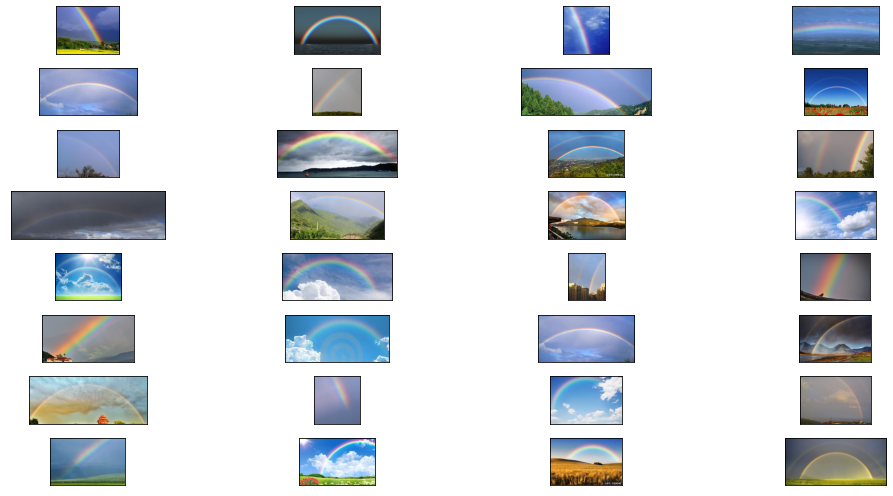

In [66]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'rainbow'].reset_index().File_Path[i]))
#     ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()

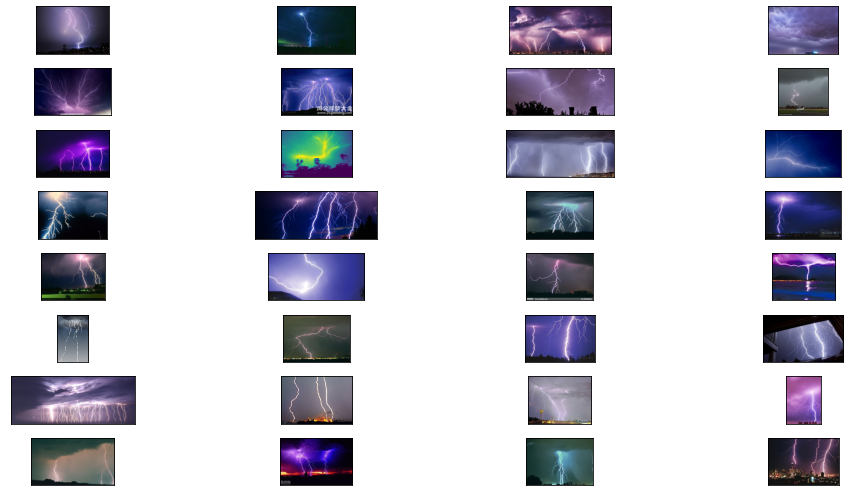

In [67]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'lightning'].reset_index().File_Path[i]))
#     ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()

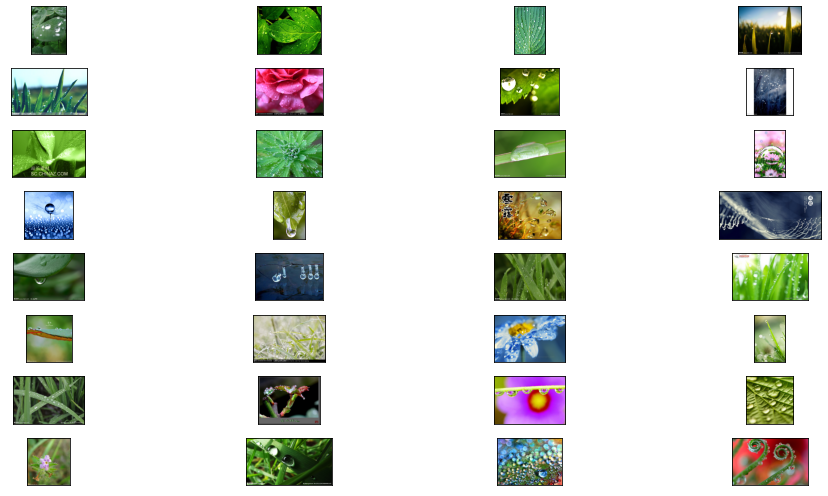

In [68]:
# read each jpg files image and into dataframe colummn called "Images"

fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(weather_data[weather_data["Labels"] == 'dew'].reset_index().File_Path[i]))
    #ax.set_title(weather_data.Labels[i])
plt.tight_layout()
plt.show()



### calculate stats on each images and EDA

In [69]:
def rainbow_histogram_plotting(imag_data):
    for col, channel in zip('rgb', np.rollaxis(imag_data , axis=-1)):
        hist, bin_centers = exposure.histogram(channel)
        plt.fill_between(bin_centers, hist, color=col, alpha=0.4)
    plt.title('rainbow Histogram', fontsize=15)
    plt.show()

In [70]:
# convert image into numpy array:
# https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/

from PIL import Image
from numpy import asarray
  
#   sample.png is the name of the image
# file and assuming that it is uploaded
# in the current directory or we need
# to give the path

## summarize some details about the image
# print(image.format)
# print(image.size)
# print(image.mode)

img_mean_val = []
img_median_val = []
img_shape_val = []
img_colors = []


for path in weather_data.File_Path :
#     print(path)
    image = Image.open(path)
    # convert image into numpy array
    numpydata = asarray(image)
#     print(image)

    img_mean_val.append(numpydata.mean())
    img_median_val.append(np.median(numpydata))
    img_shape_val.append(numpydata.shape)

    # gather the colors of the images:
    color_dicts = dict(zip('rgb', np.rollaxis(numpydata , axis=-1)))
    img_colors.append(tuple(color_dicts.keys()))


weather_data['img_mean_val'] = img_mean_val
weather_data['img_median_val'] = img_median_val
weather_data['img_shape_val'] = img_shape_val
weather_data['img_colors'] = img_colors


def multiple_yourself(object_items):
    res = 1
    for i in object_items:

        res = res * i 

    return res

size_amount_val = []
for i in weather_data['img_shape_val']:
    size_amount_val.append(multiple_yourself(i)/1000 )
    
weather_data["imag_matrix_size(per 1000)"] = size_amount_val
  

In [71]:
weather_data.head(15)

,File_Path,Labels,weather_classes,img_mean_val,img_median_val,img_shape_val,img_colors,imag_matrix_size(per 1000)
0,/Users/zhangjingyu/Desktop/dataset/rainbow/078...,rainbow,1,148.882390,131.0,"(300, 400, 4)","(r, g, b)",480.000
1,/Users/zhangjingyu/Desktop/dataset/rainbow/076...,rainbow,1,81.316482,72.0,"(259, 470, 3)","(r, g, b)",365.190
2,/Users/zhangjingyu/Desktop/dataset/rainbow/067...,rainbow,1,134.457689,138.0,"(557, 549, 3)","(r, g, b)",917.379
3,/Users/zhangjingyu/Desktop/dataset/rainbow/076...,rainbow,1,124.376988,120.0,"(215, 395, 3)","(r, g, b)",254.775
4,/Users/zhangjingyu/Desktop/dataset/rainbow/060...,rainbow,1,164.831665,164.0,"(142, 294, 3)","(r, g, b)",125.244
5,/Users/zhangjingyu/Desktop/dataset/rainbow/072...,rainbow,1,148.189331,153.0,"(525, 545, 3)","(r, g, b)",858.375
6,/Users/zhangjingyu/Desktop/dataset/rainbow/060...,rainbow,1,148.314148,151.0,"(206, 564, 3)","(r, g, b)",348.552
7,/Users/zhangjingyu/Desktop/dataset/rainbow/068...,rainbow,1,105.989112,100.0,"(755, 1007, 3)","(r, g, b)",2280.855
8,/Users/zhangjingyu/Desktop/dataset/rainbow/063...,rainbow,1,151.587079,148.0,"(603, 786, 3)","(r, g, b)",1421.874
9,/Users/zhangjingyu/Desktop/dataset/rainbow/082...,rainbow,1,141.965829,150.0,"(403, 1015, 3)","(r, g, b)",1227.135


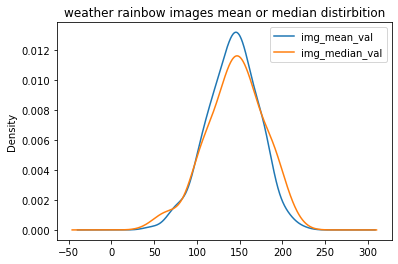

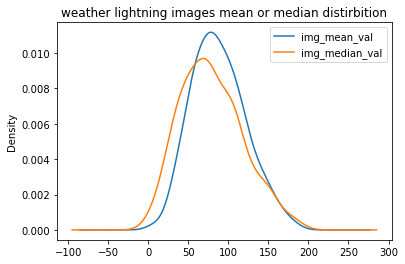

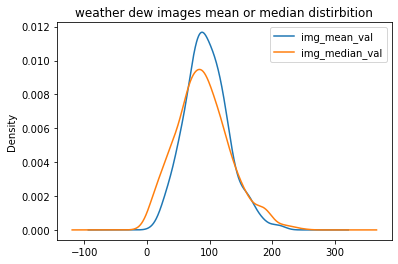

In [72]:
for weather_item in ['rainbow','lightning', 'dew']:
    s_df = weather_data[weather_data['Labels'] == weather_item][['img_mean_val', 'img_median_val']]

    ax = s_df.plot.kde(title ="weather {} images mean or median distirbition".format(weather_item))
#     ax.title("weather {} images mean distirbition".format(weather_item))

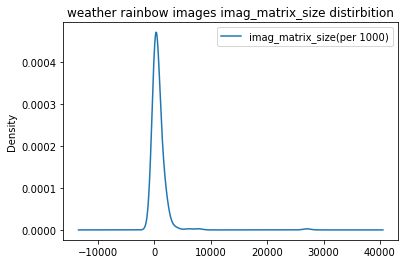

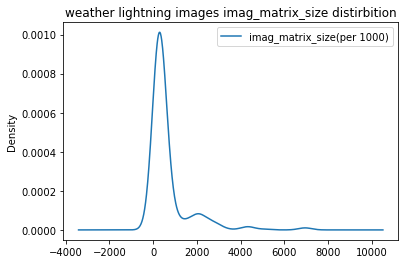

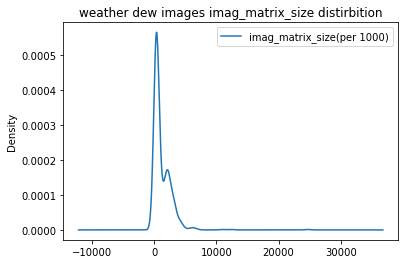

In [73]:
for weather_item in ['rainbow','lightning', 'dew']:
    s_df = weather_data[weather_data['Labels'] == weather_item][['imag_matrix_size(per 1000)']]

    ax = s_df.plot.kde(title ="weather {} images imag_matrix_size distirbition".format(weather_item))

Read and preProcess Images into X an y

In [190]:

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = np.array(image)/255.0
    return image


def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

In [193]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = '/Users/zhangjingyu/Desktop/dataset/'
dir_types = [ 'rainbow','lightning', 'dew']

# split train and test 80 :20

for label in dir_types:
    for image in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image)
        all_labels.append(label)

# pick a good amount of data to do 80/20 train split test IE, 1710 * 0.2 = 342 + 4 = 346 test dataset 
rest_paths, rest_labels = all_paths[1700:], all_labels[1700:] # take out the last 4 samples aside, layter get joined with test set 
all_paths, all_labels = all_paths[:1700], all_labels[:1700] # take the first 1710 amount of data for 80/20 split

all_paths_train_test_split, all_labels_train_test_split = shuffle(all_paths, all_labels)
train_index = int(0.8 * len(all_paths_train_test_split) +1 )
# print(train_index)
x_train_paths = all_paths_train_test_split[:train_index-1]
y_train = all_labels_train_test_split[:train_index-1]
x_test_paths = all_paths_train_test_split[train_index-1:] + rest_paths
y_test = all_labels_train_test_split[train_index-1:] + rest_labels

# save the images from the train set into later train set evaluation
x_test_val_paths = all_paths_train_test_split[train_index-1:] + rest_paths
y_test_val_paths = all_labels_train_test_split[train_index-1:] + rest_labels

print(x_train_paths)
print(len(y_train))

print(len(x_test_paths))
print(len(y_test))

# print(len(x_train_val_paths))
# print(len(y_test_vals_paths))


['/Users/zhangjingyu/Desktop/dataset/lightning/1892.jpg', '/Users/zhangjingyu/Desktop/dataset/rainbow/0644.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2600.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2443.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2252.jpg', '/Users/zhangjingyu/Desktop/dataset/lightning/1994.jpg', '/Users/zhangjingyu/Desktop/dataset/lightning/2201.jpg', '/Users/zhangjingyu/Desktop/dataset/rainbow/0696.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2859.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2514.jpg', '/Users/zhangjingyu/Desktop/dataset/rainbow/0690.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2426.jpg', '/Users/zhangjingyu/Desktop/dataset/lightning/2073.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2531.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2570.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2493.jpg', '/Users/zhangjingyu/Desktop/dataset/rainbow/0680.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2258.jpg', '/Users/zhangjingyu/Desktop/dataset/dew/2

In [194]:
# remove all the files from folders 

def remove_files(file_lst):
    
    for filePath in file_lst:
        if os.path.exists(filePath):
            os.remove(filePath)
        else:
            print("Can not delete the file as it doesn't exists")


filePaths = [list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_test/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_train/lightning1/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_train/rainbow1/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_train/dew1/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_test/lightning2/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_test/rainbow2/*.jpg")),
        list(glob.glob("/Users/zhangjingyu/Desktop/dataset/dataset_test/dew2/*.jpg"))
    ]

print(filePaths)
for file_lst in filePaths:
    remove_files(file_lst)
    


[['/Users/zhangjingyu/Desktop/dataset/dataset_test/2672.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2128.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2869.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2302.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2470.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2316.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/0677.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2048.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/0688.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2713.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2075.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/1971.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2263.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2277.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2854.jpg', '/Users/zhangjingyu/Desktop/dataset/dataset_test/2868.jpg', '/Users/zhangjingyu/Desktop/dataset/da

In [195]:
#create Train and test set folder for data
import shutil
for src2 in x_test_paths:
    shutil.copy(src2, '/Users/zhangjingyu/Desktop/dataset/dataset_test')
    


In [196]:
x_test_paths

['/Users/zhangjingyu/Desktop/dataset/rainbow/0679.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1835.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2222.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2601.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1839.jpg',
 '/Users/zhangjingyu/Desktop/dataset/rainbow/0789.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2325.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/2016.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2798.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2659.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/2144.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1968.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1986.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2808.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2457.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2307.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1992.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2692.jpg',
 '/Users/zhang

In [197]:
# import shutil
for src2 in x_test_paths:
    if "rainbow" in src2:
        shutil.copy( src2, "/Users/zhangjingyu/Desktop/dataset/dataset_test/rainbow2")
    elif "lightning" in src2:
        shutil.copy( src2, "/Users/zhangjingyu/Desktop/dataset/dataset_test/lightning2")
    else:
        shutil.copy( src2, "/Users/zhangjingyu/Desktop/dataset/dataset_test/dew2")

In [198]:
#create Train and test set folder for data 

for src in x_train_paths:
    if "lightning" in src:
        shutil.copy( src, "/Users/zhangjingyu/Desktop/dataset/dataset_train/lightning1")
    elif "dew" in src:
        shutil.copy( src, "/Users/zhangjingyu/Desktop/dataset/dataset_train/dew1")
    else:
        shutil.copy( src, "/Users/zhangjingyu/Desktop/dataset/dataset_train/glaze1")
    

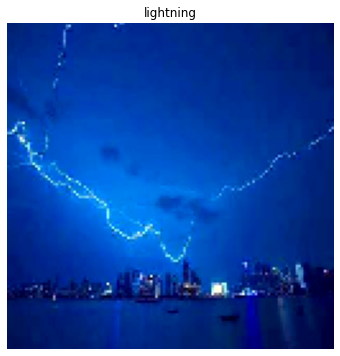

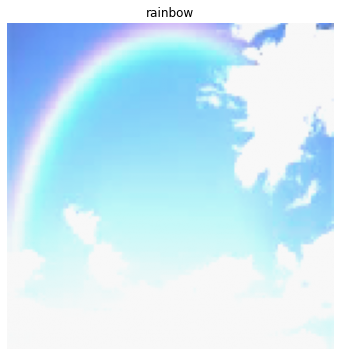

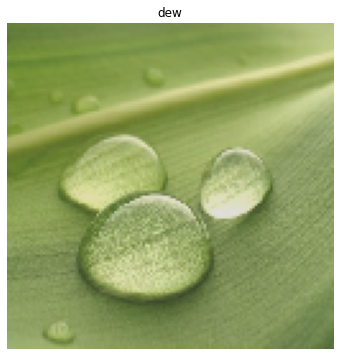

In [199]:
num_images = 3
images = open_images(x_train_paths[:num_images])

for x in range(0, num_images):
#     fig.add_subplot(2,4, x)
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
    plt.show()

In [200]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

# build training dataset generator
path = "/Users/zhangjingyu/Desktop/dataset/dataset_train"
target_size = (128, 128)
batch_size = 2
class_mode = 'categorical'

train_generator = train_datagen.flow_from_directory(
    directory = path,
    color_mode="rgb",
    target_size = target_size,
    class_mode = class_mode,   
    batch_size = batch_size,  
    shuffle=True,
    seed=42
)

# check category labels
print(train_generator.class_indices)
# print(y_test)

Found 856 images belonging to 3 classes.
{'dew1': 0, 'lightning1': 1, 'rainbow1': 2}


In [201]:
valid_generator = train_datagen.flow_from_directory(
    directory="/Users/zhangjingyu/Desktop/dataset/dataset_train",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 856 images belonging to 3 classes.


In [202]:
test_generator = train_datagen.flow_from_directory(
    directory="/Users/zhangjingyu/Desktop/dataset/dataset_test",
  target_size=(128, 128),
    color_mode="rgb",
    batch_size=2,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 261 images belonging to 3 classes.


In [203]:
unique_labels = os.listdir('/Users/zhangjingyu/Desktop/dataset/dataset_train')
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)


def data_gen(paths, labels, batch_size=12):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

### ResNet Transfer learning model 

Resnet has been trained on thousdand of hundreds of imges before

Without training the model with a train set, use a resNet pretrained CNN model to directly apply to the test set of images and identify each image and get the accuracy as part of the model exploratiary analysis 

In [204]:
from tensorflow.keras.applications import resnet50, densenet
from tensorflow.keras.preprocessing import image

model = resnet50.ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [205]:
x_test_paths

['/Users/zhangjingyu/Desktop/dataset/rainbow/0679.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1835.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2222.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2601.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1839.jpg',
 '/Users/zhangjingyu/Desktop/dataset/rainbow/0789.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2325.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/2016.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2798.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2659.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/2144.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1968.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1986.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2808.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2457.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2307.jpg',
 '/Users/zhangjingyu/Desktop/dataset/lightning/1992.jpg',
 '/Users/zhangjingyu/Desktop/dataset/dew/2692.jpg',
 '/Users/zhang

In [206]:
# print(x_test_paths)
print(y_test)

['rainbow', 'lightning', 'dew', 'dew', 'lightning', 'rainbow', 'dew', 'lightning', 'dew', 'dew', 'lightning', 'lightning', 'lightning', 'dew', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'rainbow', 'dew', 'rainbow', 'dew', 'dew', 'rainbow', 'dew', 'dew', 'lightning', 'lightning', 'rainbow', 'rainbow', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'dew', 'rainbow', 'lightning', 'lightning', 'dew', 'dew', 'lightning', 'rainbow', 'dew', 'lightning', 'lightning', 'lightning', 'dew', 'dew', 'rainbow', 'dew', 'lightning', 'rainbow', 'lightning', 'dew', 'lightning', 'lightning', 'lightning', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'rainbow', 'rainbow', 'dew', 'dew', 'rainbow', 'lightning', 'dew', 'dew', 'lightning', 'dew', 'dew', 'lightning', 'lightning', 'lightning', 'dew', 'rainbow', 'lightning', 'dew', 'dew', 'lightning', 'dew', 'dew', 'dew', 'dew', 'dew', 'lightning', 'lightning', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'dew', 'lig

In [207]:
result_reNet = {}
for i in range(0, len(x_test_paths)):
    
#     print(x_test_paths[i])
    # Load the image file, resizing it to 224x224 pixels (required by this model)
    img = image.load_img( x_test_paths[i], target_size=(224, 224) )
    #img = image.load_img("images/timessq.jpg", target_size=(224, 1000))

#     plt.imshow(img)

    # Convert the image to a numpy array
    x = image.img_to_array(img)

    # Add a forth dimension since Keras expects a list of images
    x = np.expand_dims(x, axis=0)
    
    # Scale the input image to the range used in the trained network
    x = resnet50.preprocess_input(x)
    
    # Run the image through the deep neural network to make a prediction
    predictions = model.predict(x)

    # Look up the names of the predicted classes. Index zero is the results for the first image.
    predicted_classes = resnet50.decode_predictions(predictions, top=6)

#     print("This is an image of:")
    
    names = []
    likelihoods = []

    for imagenet_id, name, likelihood in predicted_classes[0]:
        names.append(name)
        likelihoods.append(likelihood)
    
    # capture predicted top names, likelihood and true label fo each image
    result_reNet[x_test_paths[i]] = [names, likelihoods, y_test[i]]
    

   

In [208]:
# compare against the true label if the top 3 prediction class matches the true label and how many was correctly predicted ?
dew_list = []
rainbow_list = []
lightening_list = []
for i in result_reNet.values():
    if "dew" in i:
        dew_list = dew_list  + i[0]
    elif "rainbow" in i:
        rainbow_list = rainbow_list  + i[0]
    
    else:
        lightening_list = lightening_list  + i[0]
        
dew_lst = list(set(dew_list))
rainbow_lst = list(set(rainbow_list))
lightening_lst = list(set(lightening_list ))
        


In [209]:
frequency_dew = {}
for item in dew_lst:
    frequency_dew[item] = dew_list.count(item)
frequency_dew = {k: v for k, v in sorted(frequency_dew.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_dew)


Frequency of items:  {'spider_web': 36, 'bubble': 36, 'ant': 30, 'leafhopper': 22, 'leaf_beetle': 22, 'ladybug': 19, 'cucumber': 19, 'damselfly': 17, 'dragonfly': 14, 'fountain': 13, 'lycaenid': 12, 'lacewing': 12, 'green_snake': 12, 'head_cabbage': 11, 'shower_curtain': 11, 'garden_spider': 10, 'tree_frog': 10, 'vine_snake': 10, 'fly': 9, 'nematode': 9, 'daisy': 9, 'spotlight': 9, 'bee': 8, 'water_bottle': 8, 'snail': 8, 'broccoli': 7, 'weevil': 7, 'jellyfish': 7, 'American_chameleon': 7, 'coral_reef': 7, 'acorn': 6, 'hummingbird': 6, 'mushroom': 6, 'black_and_gold_garden_spider': 6, 'barn_spider': 6, 'lemon': 6, 'sea_anemone': 6, 'bell_pepper': 6, 'tick': 6, 'golf_ball': 6, 'fig': 5, 'electric_ray': 5, 'cardoon': 5, 'pot': 5, 'ringlet': 5, 'sulphur_butterfly': 5, 'wolf_spider': 5, 'hip': 5, 'hair_slide': 5, 'cricket': 5, 'grasshopper': 5, 'cabbage_butterfly': 5, 'Granny_Smith': 5, 'strainer': 4, 'artichoke': 4, "yellow_lady's_slipper": 4, 'umbrella': 4, 'stage': 4, 'goblet': 4, 'stra

In [210]:

frequency_rainbow = {}
for item in rainbow_lst:
    frequency_rainbow[item] = rainbow_list.count(item)
frequency_rainbow = {k: v for k, v in sorted(frequency_rainbow.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_rainbow)


Frequency of items:  {'fountain': 34, 'fireboat': 21, 'lakeside': 19, 'bubble': 14, 'geyser': 14, 'volcano': 11, 'balloon': 10, 'alp': 6, 'valley': 5, 'church': 5, 'seashore': 5, 'matchstick': 5, 'rapeseed': 4, 'wing': 4, 'hay': 4, 'cliff': 4, 'spotlight': 4, 'greenhouse': 4, 'jellyfish': 3, 'steel_arch_bridge': 3, 'sandbar': 3, 'promontory': 3, 'planetarium': 3, 'trailer_truck': 3, 'barn': 2, 'missile': 2, 'bucket': 2, 'viaduct': 2, 'loupe': 2, 'projectile': 2, 'television': 2, 'mosque': 2, 'beacon': 2, 'space_shuttle': 2, 'Petri_dish': 2, 'torch': 2, 'screen': 1, 'castle': 1, 'palace': 1, 'sunglasses': 1, 'boathouse': 1, 'pier': 1, 'dock': 1, 'sunglass': 1, 'monitor': 1, 'caldron': 1, 'pinwheel': 1, 'water_tower': 1, 'park_bench': 1, 'groom': 1, 'coral_reef': 1, 'warplane': 1, 'maypole': 1, 'mountain_tent': 1, 'vault': 1, 'stove': 1, 'traffic_light': 1, 'wok': 1, 'breakwater': 1, 'liner': 1, 'tank': 1, 'parking_meter': 1, 'parachute': 1, 'canoe': 1, 'grey_whale': 1, 'stupa': 1, 'fire

In [211]:
frequency_lightening = {}
for item in lightening_lst:
    frequency_lightening[item] = lightening_list.count(item)
frequency_lightening = {k: v for k, v in sorted(frequency_lightening.items(), key=lambda item: item[1], reverse=True)}
print("Frequency of items: ", frequency_lightening)



Frequency of items:  {'fountain': 49, 'volcano': 39, 'stage': 36, 'geyser': 36, 'spotlight': 31, 'spider_web': 22, 'monitor': 21, 'alp': 17, 'missile': 16, 'jellyfish': 13, 'beacon': 12, 'space_shuttle': 11, 'garden_spider': 10, 'oscilloscope': 10, 'theater_curtain': 10, 'loudspeaker': 8, 'parachute': 8, 'pole': 8, 'microphone': 7, 'fireboat': 6, 'barn': 6, 'matchstick': 5, 'torch': 5, 'television': 5, 'church': 5, 'home_theater': 5, 'screen': 4, 'web_site': 4, 'dock': 4, 'projectile': 4, 'obelisk': 4, 'shower_curtain': 4, 'cliff': 4, 'balloon': 4, 'valley': 3, 'wing': 3, 'flagpole': 3, 'seashore': 3, 'bubble': 3, 'castle': 3, 'lakeside': 3, 'traffic_light': 2, 'desktop_computer': 2, 'caldron': 2, 'solar_dish': 2, 'hair_spray': 2, 'breakwater': 2, 'cannon': 2, 'laptop': 2, 'tripod': 2, 'analog_clock': 2, 'park_bench': 2, 'assault_rifle': 1, 'airliner': 1, 'cash_machine': 1, 'water_tower': 1, 'lighter': 1, 'warplane': 1, 'scuba_diver': 1, 'amphibian': 1, 'steel_arch_bridge': 1, 'noteboo

### Start a basic CNN Model as a Baseline

In [224]:
#------------ build a CNN from scratch by imitating vgg16


model = Sequential()
model.add(Conv2D(input_shape=(128, 128 ,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

model.save_weights("/Users/zhangjingyu/Desktop/dataset/saved_models/new_initial_weights.h5")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_92 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_94 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                 

In [241]:
batch_size=1
epochs=4
steps = int(len(x_train_paths)/batch_size/epochs)
len(x_train_paths)
epochs
# steps
# train for 8-12 epochs
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=steps)


Epoch 1/4
  1/260 [..............................] - ETA: 1:52 - loss: 1.3755 - accuracy: 1.0000

InvalidArgumentError: Graph execution error:

ValueError: 'rainbow' is not in list
Traceback (most recent call last):

  File "/Users/zhangjingyu/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/Users/zhangjingyu/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/Users/zhangjingyu/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/zhangjingyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "<ipython-input-203-b5661700f57c>", line 24, in data_gen
    batch_labels = encode_label(batch_labels)

  File "<ipython-input-203-b5661700f57c>", line 5, in encode_label
    encoded.append(unique_labels.index(x))

ValueError: 'rainbow' is not in list


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_110492]

In [244]:
filename = 'normal_cnn'
model_yaml = model.to_yaml()
with open("saved_models/" + filename + ".yaml", 'w') as yaml_file: 
    yaml_file.write(model_yaml)
weights_file = "saved_models/" + filename + ".h5"
model.save_weights(weights_file)
print("Model saved to disk")

RuntimeError: Method `model.to_yaml()` has been removed due to security risk of arbitrary code execution. Please use `model.to_json()` instead.

In [245]:
steps = int(len(x_val_paths)/batch_size)

In [246]:
len(x_test_paths)/2

130.5

In [247]:
batch_size=8
steps = int(len(x_test_paths)/batch_size)

y_pred_model = []
y_true_model = []

for x,y in tqdm(data_gen(x_test_paths, y_test, batch_size=batch_size), total=steps):
    pred_model = model.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_model.append(i)
    for i in y:
        y_true_model.append(i)

  0%|          | 0/32 [00:00<?, ?it/s]


ValueError: 'rainbow' is not in list

In [248]:
print(y_pred_model)

[]


In [249]:
print(y_true_model)

[]


In [250]:
print(classification_report(y_true_model, y_pred_model))

ValueError: max() arg is an empty sequence

test if the model is over/under-fitting 

In [251]:
# apply on train set 
batch_size=4
epochs=6
steps = int(len(x_train_paths)/batch_size/epochs)
y_pred_train_model = []
y_true_train_model = []

for x,y in tqdm(data_gen(x_train_paths, y_train, batch_size=batch_size), total=steps):
    pred_model = model.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_train_model.append(i)
    for i in y:
        y_true_train_model.append(i)

  0%|          | 0/43 [00:00<?, ?it/s]


ValueError: 'rainbow' is not in list

In [252]:
print(classification_report(y_true_train_model, y_pred_train_model))

ValueError: max() arg is an empty sequence

as we can see that our CNN model is not over/underfitting when compare the train or test set performances

### Implement pre-train Nueral Networks on the Image Processing 

VGG16

In [253]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# load the model
vgg16 = VGG16(input_shape=(128, 128,3), include_top=False, weights='imagenet')

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [254]:
model_vgg16 = Sequential()
model_vgg16.add(Input(shape=(128, 128, 3)))
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(768, activation='relu'))
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.25))
model_vgg16.add(Dense(4, activation='softmax'))
model_vgg16.summary()

model_vgg16.compile( loss = 'sparse_categorical_crossentropy',
#     loss = 'categorical_crossentropy', 
              optimizer =keras.optimizers.Adam(learning_rate=0.0001), 
              metrics = ["accuracy"])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_6 (Dropout)         (None, 8192)              0         
                                                                 
 dense_30 (Dense)            (None, 768)               6292224   
                                                                 
 dropout_7 (Dropout)         (None, 768)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               196864    
                                                                 
 dropout_8 (Dropout)         (None, 256)             

In [265]:
# steps_per_epochs = 32
# epochs = 50

# vgg_history = run_model(steps_per_epoch= steps_per_epochs,epochs = epochs, CNN_model= model_vgg16, model_output_name = "vgg16_cnn" , run_epochs=False )

batch_size = 521
steps = int(len(x_train_paths)/batch_size)
epochs=2 # train for 8-12 epochs
for _ in range(epochs):
    model_vgg16.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=2, steps_per_epoch=steps)



UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fb011b8d360>

In [ ]:
filename = 'vgg16_cnn'
model_yaml = model.to_yaml()
with open("saved_models/" + filename + ".yaml", 'w') as yaml_file: 
    yaml_file.write(model_yaml)
weights_file = "saved_models/" + filename + ".h5"
model_vgg16.save_weights(weights_file)
print("Model saved to disk")

result preduction label: lighting: 0, dew = 3, glaze = 1

In [179]:
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []

for x,y in tqdm(data_gen(x_test_paths, y_test, batch_size=batch_size), total=steps):
    pred = model_vgg16.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)


0it [00:00, ?it/s]


ValueError: 'rainbow' is not in list

In [180]:
print(y_pred)

[]


In [181]:
print(y_true)

[]


In [182]:
print(y_test)

['lightning', 'dew', 'dew', 'dew', 'dew', 'dew', 'dew', 'rainbow', 'dew', 'dew', 'dew', 'dew', 'dew', 'rainbow', 'lightning', 'dew', 'rainbow', 'dew', 'dew', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'dew', 'rainbow', 'lightning', 'dew', 'lightning', 'dew', 'dew', 'lightning', 'rainbow', 'dew', 'dew', 'dew', 'lightning', 'dew', 'rainbow', 'rainbow', 'dew', 'lightning', 'dew', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'lightning', 'lightning', 'rainbow', 'dew', 'lightning', 'lightning', 'lightning', 'rainbow', 'lightning', 'rainbow', 'dew', 'dew', 'dew', 'dew', 'dew', 'lightning', 'dew', 'dew', 'lightning', 'lightning', 'lightning', 'lightning', 'lightning', 'lightning', 'rainbow', 'dew', 'lightning', 'dew', 'lightning', 'lightning', 'dew', 'dew', 'rainbow', 'lightning', 'lightning', 'lightning', 'lightning', 'dew', 'dew', 'dew', 'dew', 'lightning', 'dew', 'lightning', 'dew', 'rainbow', 'dew', 'dew', 'lightning', 'lightning

In [183]:
print(classification_report(y_true, y_pred))

ValueError: max() arg is an empty sequence

If the vgg16 model is over/underfitting 

In [184]:
# apply on train set 
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred_train_model = []
y_true_train_model = []

for x,y in tqdm(data_gen(x_train_paths, y_train, batch_size=batch_size), total=steps):
    pred_model = model_vgg16.predict(x)
    pred_model = np.argmax(pred_model, axis=-1)
    for i in pred_model:
        y_pred_train_model.append(i)
    for i in y:
        y_true_train_model.append(i)

0it [00:00, ?it/s]


ValueError: 'rainbow' is not in list

In [185]:
print(classification_report(y_true_train_model, y_pred_train_model))

ValueError: max() arg is an empty sequence

the vgg16 transfer learning model is a little underfitted since the model is alittle underperformanced when apply to the train set when compare to the the test set

## Compare CNN vs Vgg16 Transfer Learning Model 

CNN that imitates Vgg16 model as baseline model provide a pretty good performaning classification predictions by showing steady evaluation that are over 87%-91% in accruacy and f-1 score in both train set and test set 

Vgg16 transfer learning model does have a little underfitting issue (space for improvement). However, vgg16 model does display bettern accuracy (88%-93%) and f1 score result (86-95%)


In [186]:
model model_vgg16

SyntaxError: invalid syntax (<ipython-input-186-5c0df3f7d990>, line 1)

In [187]:
cnn_model_label = {"glaze": 1, "lightning": 0, "dew":  3}
vgg16_model_label = {"glaze": 1, "lightning": 0, "dew":  3}